# Fit an Ising model to the concentration data that we have as described in Broderick et al. 2007 
https://arxiv.org/abs/0712.2437

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap, lax, jit, tree_util, nn
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14
from matplotlib.gridspec import GridSpec
import pandas as pd

In [2]:
DATA_PATH = '../vcf/Matrix2.csv'

In [19]:
oim.downsampled_data.shape

(43, 1384)

In [100]:
class OlfactionIsingModel:
    def __init__(self, data_path):
        self.data_path = data_path
        self.load_data() 
    
    def load_data(self): 
        self.data = pd.read_csv(self.data_path, index_col=0) 

    def subset_top_n_odorants(self, n):
        sums = jnp.sum(self.data.values, axis=1)
        cutoff_value = jnp.sort(sums)[-n]
        indices = jnp.where(sums >= cutoff_value)[0]
        filtered_data = self.data.iloc[indices, :] 
        self.top_n_data = filtered_data
        return filtered_data
    
    def downsample_odorants(self, key, fraction=.01): 
        num_rows = self.data.shape[0]
        indices = jax.random.choice(key, jnp.arange(num_rows), shape=(int(fraction * num_rows), ))
        self.downsampled_data = self.data.iloc[indices, :]

    def energy(self, s, h, J): 
        return - (h @ s + s @ J @ s)
    
    def update(self, state, _):
        key, s = state
        key, subkey = jax.random.split(key)
        i = jax.random.choice(subkey, jnp.arange(len(s)))  # Randomly choose a spin
        # see https://sites.stat.washington.edu/mmp/courses/stat534/spring19/Handouts/lecture-may21.pdf for an easy overview of how conditional prob becomes sigmoid
        contribution = self.beta * (self.h[i] + self.J[i, :] @ s)  # Compute local field
        p_plus = nn.sigmoid(2 * contribution)
        key, subkey = jax.random.split(key)
        s = s.at[i].set(jnp.where(jax.random.uniform(subkey) < p_plus, 1, -1))
        return (key, s), s  # Return new state and spins
    
    def sample_from_ising_model(self, key, h, J, s_init=None, iters=1, beta=1):
        if s_init is None:
            s_init = jax.random.bernoulli(key, p=0.5, shape=(len(h),)) * 2 - 1  # Initialize spins (-1, 1)
        # Run Gibbs sampling with lax.scan
        self.beta, self.h, self.J = beta, h, J 
        (final_state, spins), spin_trajectory = jax.lax.scan(
            self.update, (key, s_init), None, length=iters)
        return spin_trajectory.T
    
    def compute_magnetization(self, vals): 
        return jnp.sum(vals, axis=0) 
    
    def tau_vs_beta(self, key, h, J, betas): 
        taus = []
        for beta in betas: 
            vals = self.sample_from_ising_model(key, h, J, iters=1000, beta=beta)
            m = self.compute_magnetization(vals) 
            tau = self.estimate_autocorrelation_time(m)
            taus.append(tau) 
        return betas, taus 
    
    def autocorrelation(self, chain, lag):
        """Compute autocorrelation at a given lag."""
        n = len(chain)
        mean = jnp.mean(chain)
        var =  jnp.var(chain)
        if var == 0:
            return 0
        return jnp.sum((chain[:n-lag] - mean) * (chain[lag:] - mean)) / (var * (n - lag))

    def estimate_autocorrelation_time(self, chain, max_lag=200):
        """Estimate the autocorrelation time."""
        autocorrs = [self.autocorrelation(chain, lag) for lag in range(max_lag)]
        for lag, corr in enumerate(autocorrs):
            if corr < 0.1:  # Threshold for approximate independence
                return lag
        return max_lag  # Return max_lag if no decorrelation is found
    
    def generate_independent_samples(self, key, h, J, samples, burnin=1000, tau=150):
        iterations = samples * tau + burnin # this is an estimate of tau + 1000 for burn in. 
        vals = self.sample_from_ising_model(key, h, J, iters=iterations) # remember beta is fixed to 1 here and abosrbed in the parameters. 
        independent_samples = vals[:, 1000::150]
        return independent_samples

    def compute_MC_expectations(self, samples, h_MC, J_MC, h_current, J_current): # here we're using their clever importance-sampling-style histogram MC trick. see https://arxiv.org/pdf/0712.2437
        h_diff, J_diff = h_current - h_MC, J_current - J_MC 
        unnormalized_weights = jnp.exp(h_diff @ samples + jnp.diagonal(samples.T @ J_diff @ samples))  # this should be the same dimension as number of samples 
        weights = unnormalized_weights / jnp.sum(unnormalized_weights)
        Q_mean = jnp.average(samples, axis=1, weights=weights)
        outer_product = jnp.einsum('ip,jp->ijp', samples, samples)
        Q_cov = jnp.average(outer_product, axis=-1, weights=weights) 
        return Q_mean, Q_cov
    
    def compute_empirical_means(self): 
        self.empirical_mean = jnp.average(self.downsampled_data.values, axis=1)
        outer_product = jnp.einsum('ip,jp->ijp', self.downsampled_data.values, self.downsampled_data.values) 
        self.empirical_cov = jnp.average(outer_product, axis=-1)

    def optimize_ising_model(self, key, h_init, J_init, eta, stages=1, iterations=1): 
        self.compute_empirical_means()  # Compute empirical mean & covariance once
        

    def optimize_ising_model(self, key, h_init, J_init, eta, stages=1, iterations=1): 
        self.compute_empirical_means()  # Compute empirical mean & covariance once
        
        def inner_update(carry, _):
            h, J, samples, h_MC, J_MC = carry  # Include MC parameters in carry
            Q_mean, Q_cov = self.compute_MC_expectations(samples, h_MC, J_MC, h, J)  # Corrected line
            grad_h = Q_mean - self.empirical_mean
            grad_J = Q_cov - self.empirical_cov
            h_new = h - eta * grad_h
            J_new = J - eta * grad_J
            return (h_new, J_new, samples, h_MC, J_MC), (h_new, J_new)  # Collect trajectory

        def outer_update(carry, _):
            key, h_MC, J_MC = carry
            key, subkey = jax.random.split(key)
            samples = self.generate_independent_samples(subkey, h_MC, J_MC, samples=1000)
            (h_final, J_final, _, _, _), (h_traj, J_traj) = jax.lax.scan(
                inner_update, (h_MC, J_MC, samples, h_MC, J_MC), None, length=iterations
            )
            return (key, h_final, J_final), (h_traj, J_traj)

        (key, h_final, J_final), (h_trajectory, J_trajectory) = jax.lax.scan(
            outer_update, (key, h_init, J_init), None, length=stages
        )

        return h_final, J_final, h_trajectory, J_trajectory



    # def optimize_ising_model(self, key, h_init, J_init, eta, stages=1, iterations=1): 
    #     h_MC = h_init 
    #     J_MC = J_init 
    #     h = h_init 
    #     J = J_init 
    #     self.compute_empirical_means() 
    #     for s in range(stages):
    #         samples = self.generate_independent_samples(key, h_MC, J_MC, samples=1000)
    #         for t in range(iterations): 
    #             Q_mean, Q_cov = self.compute_MC_expectations(samples, h_MC, J_MC, h, J) 
    #             grad_h = Q_mean - self.empirical_mean
    #             grad_J = Q_cov - self.empirical_cov 
    #             h -= eta * grad_h 
    #             J -= eta * grad_J 
    #         h_MC, J_MC = h, J 
    #     return h_MC, J_MC
    
    def fit_h_to_empirical_means(self): 
        # this function fits the field parameters h to match the mean of each spin by inverting the sigmoid function 
        h = 1/2 * jnp.log(self.empirical_mean / (1 - self.empirical_mean))
        return h 


In [101]:
oim = OlfactionIsingModel(DATA_PATH)
key = jax.random.PRNGKey(3) 
oim.downsample_odorants(key, fraction=.005)
h = 1 / (4 * len(oim.downsampled_data)) * jnp.zeros(4 * len(oim.downsampled_data))
J = 1 / len(h) * jnp.ones((4 * oim.downsampled_data.shape[0], 4*oim.downsampled_data.shape[0]))
# betas = jnp.logspace(-3, 0, 5) 
vals = oim.sample_from_ising_model(key, h, J, iters=100) 

In [102]:
oim.compute_empirical_means()

In [103]:
h = oim.fit_h_to_empirical_means()
J = jnp.zeros((len(h), len(h)))

In [112]:
new_h, new_J, h_traj, J_traj = oim.optimize_ising_model(key, h, J, 1, stages=2, iterations=10)

In [122]:
h_traj[0, 9, :]

Array([6.3912196, 6.3912196, 6.3712206, 8.148687 , 6.3912196, 7.0671306,
       6.7253814, 7.0471296, 6.9157014, 6.7253814, 6.3912196, 7.5314903,
       6.3912196, 7.911345 , 6.3712206, 7.08713  , 6.685382 , 6.7053814,
       6.3712206, 6.3712206, 8.147226 , 6.351221 , 6.3912196, 6.3712206,
       6.3712206, 6.955701 , 6.9357014, 6.875702 , 6.3912196, 7.5694017,
       6.7053814, 6.291221 , 6.3912196, 7.847409 , 6.3912196, 6.351221 ,
       6.9357014, 6.351221 , 7.967226 , 6.3912196, 7.988637 , 6.3712206,
       6.3912196], dtype=float32)

In [ ]:
fig, ax = plt.subplots() 

In [ ]:
new_h 

Plot autocorrelation vs inverse temperature

In [13]:
betas = jnp.linspace(.001, .01, 50)
betas, taus = oim.tau_vs_beta(key, h, J, betas)
plt.scatter(betas, taus) 

Text(0, 0.5, '$\\langle M^2 \\rangle$')

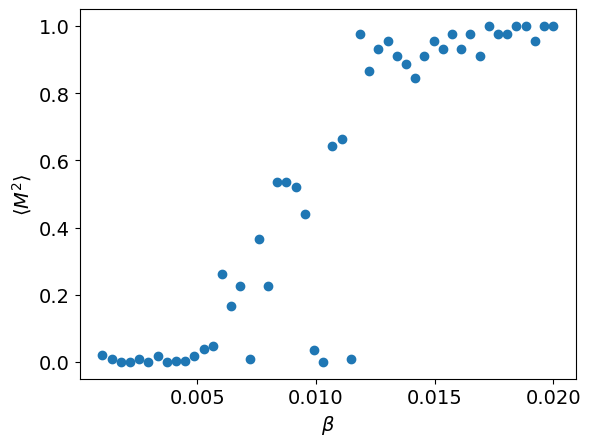

In [125]:
mags = []
for i, beta in enumerate(betas): 
    key = jax.random.PRNGKey(i)
    vals = oim.sample_from_ising_model(key, h, J, iters=1000, beta=beta)
    final_mag = 1 / vals.shape[0] * jnp.sum(vals[:, -1]) 
    mags.append(final_mag**2) 
fig, ax = plt.subplots()
ax.scatter(betas, mags)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\langle M^2 \rangle$')
# ax.set_xscale('log') 

In [126]:
vals = oim.sample_from_ising_model(key, h, J, iters=1000, beta=.002)

In [127]:
m = jnp.sum(vals, axis=0)

In [129]:
lags = [oim.autocorrelation(m, lag) for lag in range(1, 200)]

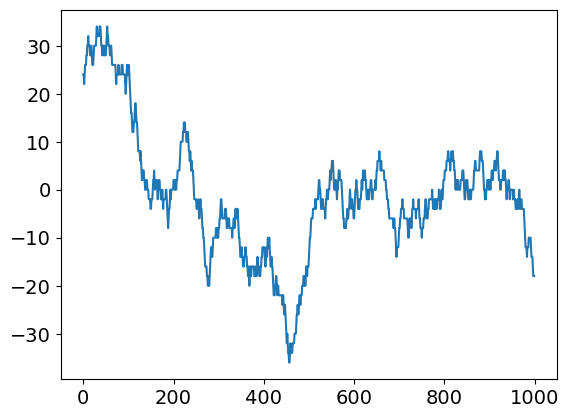

In [123]:
plt.plot(m) 

Text(0.5, 0, 'iteration')

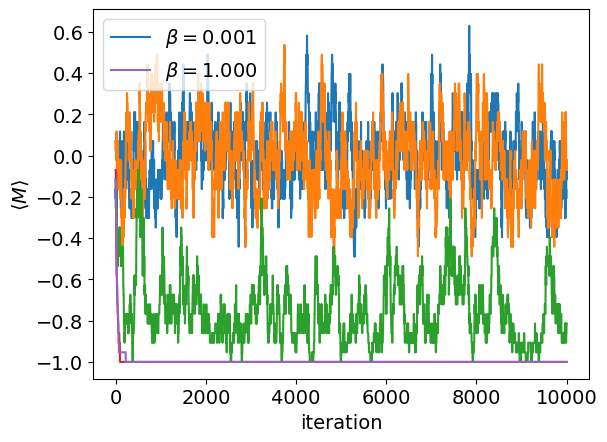

In [96]:
fig, ax = plt.subplots()

for i, beta in enumerate(betas): 
    key = jax.random.PRNGKey(i)
    vals = oim.sample_from_ising_model(key, h, J, iters=1000, beta=beta)
    if i == 0 or i == len(betas) - 1: 
        label = rf'$\beta = {beta:.3f}$'
    else: 
        label = ''
    ax.plot(1 / vals.shape[0] * vals.sum(axis=0), label=label) 
ax.legend() 
ax.set_ylabel(r'$\langle M \rangle$')
ax.set_xlabel('iteration')


In [39]:
vals = oim.sample_from_ising_model(key, h, J, iters=10000, beta=.03)

In [40]:
v = vals[:, 1000:]

In [41]:
m = jnp.sum(v, axis=0) 

In [42]:
lag = oim.estimate_autocorrelation_time(m) 

In [43]:
lag

145

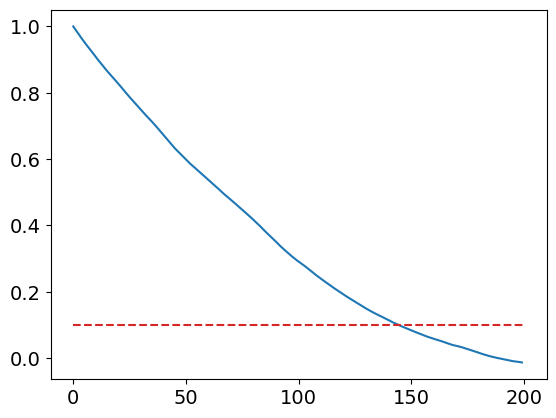

In [16]:
acs = [oim.autocorrelation(m, lag=l) for l in range(200)] 
plt.plot(range(200), acs)
plt.hlines(.1, 0, 200, ls='--', color='tab:red')

In [17]:
v.shape

(43, 9001)

In [269]:
v[:, ::150].shape

(43, 61)

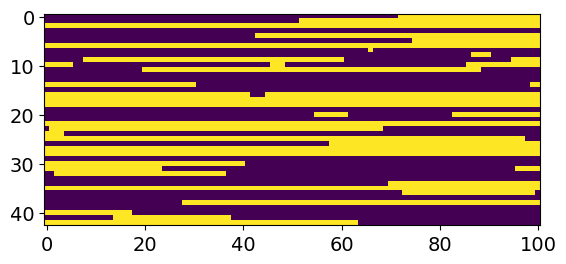

In [229]:
plt.imshow

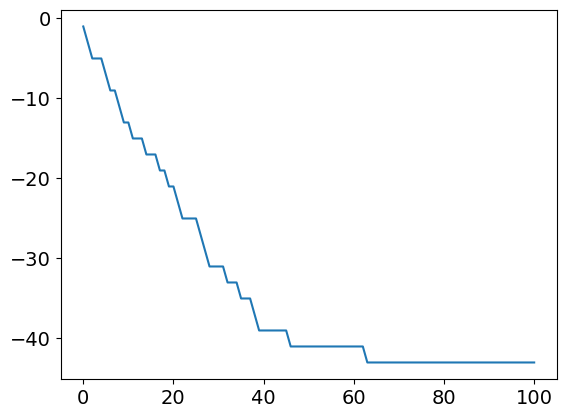

In [201]:
plt.plot(vals.sum(axis=0)[:])

In [24]:
cov = jnp.cov(oim.downsampled_data.values) 

In [25]:
eig = jnp.linalg.eig(cov) 

In [29]:
10**-.3

0.5011872336272722

In [30]:
fractions = jnp.array([.01, .03, .1, .3, .5]) 

<>:6: SyntaxWarning: invalid escape sequence '\h'
<>:6: SyntaxWarning: invalid escape sequence '\h'
/var/folders/qq/1ty9_n0n2rq91n4gcs0zkk440000gn/T/ipykernel_142/3485104052.py:6: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title('Spectrum of $\hat{\Sigma}$')
/Users/juancarlos/miniforge3/envs/olfaction/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/juancarlos/miniforge3/envs/olfaction/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


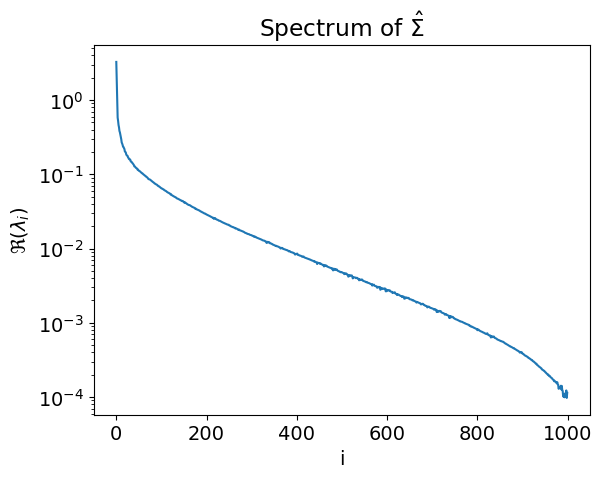

In [39]:
fig, ax = plt.subplots()
ax.plot(eig[0][:1000]) 
ax.set_yscale('log') 
ax.set_xlabel('i')
ax.set_ylabel(r'$\Re(\lambda_i)$')
ax.set_title('Spectrum of $\hat{\Sigma}$')
fig.savefig('eigenvalue_spectrum_50_percent_downsampled.png') 

0.01
0.03
0.1
0.3
0.5


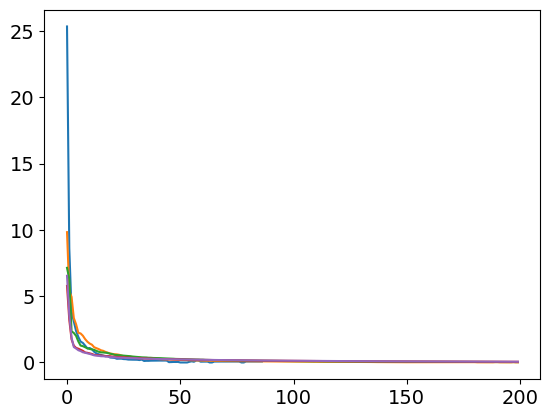

In [32]:
fig, ax = plt.subplots()
for frac in fractions: 
    print(frac) 
    oim.downsample_odorants(key, fraction=frac) 
    cov = jnp.cov(oim.downsampled_data.values) 
    eig = jnp.linalg.eig(cov)
    ax.plot(jnp.real(eig[0][:200]) / frac) 

In [164]:
oim.subset_top_n_odorants(10)

,ALMOND_HULL_(mission)_10103.html,CHESTNUT_FLOWER_27470.html,ITALIAN_CHESTNUT_(Castanea_sativa_Mill.)_(raw)_27450.html,COCONUT_MILK_8330.html,GREEN_WALNUT_HUSK_(dried_unripe)(Juglans_regia_L.)_10840.html,MACADAMIA_NUT_(Macadamia_integrifolia)_(roasted)_10210.html,ITALIAN_CHESTNUT_(Castanea_sativa_Mill.)_(roasted)_27410.html,PISTACHIO_NUT_(Pistacia_vera)_(roasted)_19620.html,CHINESE_CHESTNUT_(Castanea_molissima)_(boiled)_27440.html,ALMOND_(roasted)_(Prunus_amygdalus)_10101.html,...,POTATO_(raw)_2510.html,BEANS_(raw)_9210.html,POTATO_(cooked_or_boiled)_2540.html,DEFATTED_SOYBEAN_8220.html,NOBIRU_(Allium_grayi_Regal)_2390.html,CABBAGE_(cooked)_1820.html,CHINESE_CABBAGE_21320.html,WELSH_ONION_(Allium_fistulosum_L._var._maichuon)_2392.html,RADISH_(raw)_12610.html,CHILI_PEPPER_PERICARP_(C._baccatum)_2625.html
&alpha;-terpineol (=p-1-menthen-8-ol),0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1-hexanol,1,0,0,1,1,1,1,0,0,0,...,1,1,1,1,1,1,1,0,1,0
1-pentanol (=amyl alcohol),0,0,0,0,0,1,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
2-phenylethanol,1,1,0,0,0,1,1,1,0,0,...,0,1,1,0,0,0,1,0,0,0
3-methyl-1-butanol (=isoamyl alcohol),0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
benzaldehyde,1,1,0,0,0,1,1,0,0,1,...,1,1,1,0,0,1,0,0,0,0
hexanal,1,1,0,0,1,1,1,1,1,0,...,1,1,1,1,1,1,0,0,1,0
limonene,0,1,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
linalool,1,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
nonanal (=pelargonaldehyde),1,1,0,0,1,1,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0


In [162]:
oim.downsample_odorants(key) 

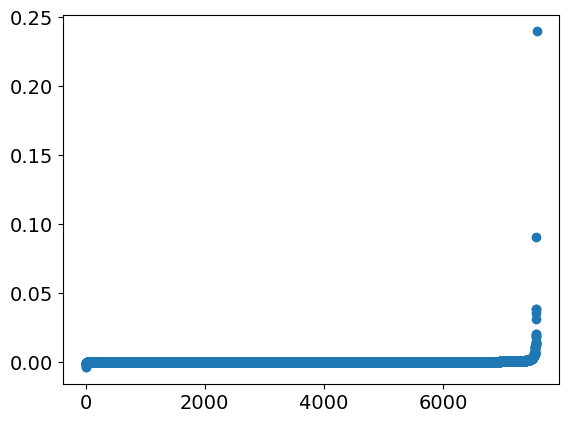

In [146]:
covs = jnp.cov(oim.downsampled_data.values).flatten() 
plt.scatter(range(len(covs)), jnp.sort(covs))

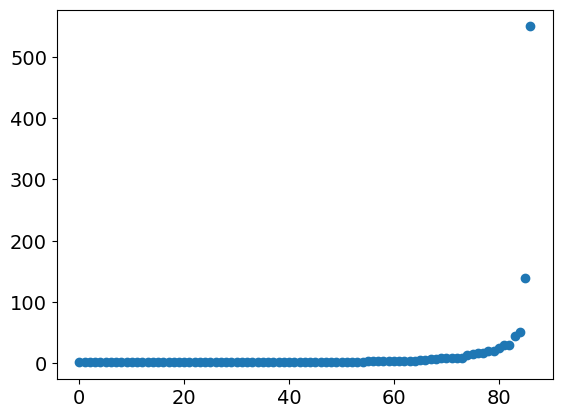

In [126]:
sums = jnp.sum(oim.downsampled_data.values, axis=1) 
plt.scatter(range(len(sums)), jnp.sort(sums))

In [127]:
sums

Array([  1,   2,   1,   2,   1,   1,   1,  51,  14,   1,   3,   1,   1,
         1,   8,   1,   1,   3, 550,   1,   1,   1,   2,  29,   1,   5,
         1,   4,   1,   2,   3,   9,   1,   2,   1,   8,   1,  44,   4,
        19,   9,   2,   1,   1,   2,   3,   8,   1,   7,   5,   1,   1,
         1,   2,   1,   3,   1,   1,   1,  15,   4,   3,  19,   1,   1,
         2,  29,   1,   1,   1,   1,   1,   1,  25,   1, 139,  16,  17,
         2,   4,   1,   6,   1,   1,   1,   2,   1], dtype=int32)